![image.png](attachment:image.png)

# √Årvores II - Tarefa 3

### 1. Carregamento dos Dados

Nesta etapa, realizamos a importa√ß√£o dos dados da base **UCI HAR Dataset**, contendo medi√ß√µes de sensores de smartphones durante diferentes atividades humanas.

Inclu√≠mos o nome das vari√°veis (features), os conjuntos de treino e teste, e as respectivas colunas de identifica√ß√£o: sujeito e atividade.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
import warnings
import requests
warnings.filterwarnings('ignore')

In [21]:
# Caminho base simplificado
base_path = 'UCI HAR Dataset/'


# Verificando se o caminho existe
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Caminho n√£o encontrado: {base_path}")

# Lendo os nomes das features
features = pd.read_csv(os.path.join(base_path, 'features.txt'), sep='\s+', header=None, names=['index', 'feature'])

# Corrigindo nomes duplicados
features['feature'] = features['feature'].apply(lambda x: x.replace('()', ''))
features['feature'] = features.groupby('feature').cumcount().astype(str) + '_' + features['feature']
feature_names = features['feature'].tolist()

# Lendo os dados de treino
X_train = pd.read_csv(os.path.join(base_path, 'train/X_train.txt'), sep='\s+', header=None, names=feature_names)
y_train = pd.read_csv(os.path.join(base_path, 'train/y_train.txt'), header=None, names=['activity'])
subject_train = pd.read_csv(os.path.join(base_path, 'train/subject_train.txt'), header=None, names=['subject'])

# Lendo os dados de teste
X_test = pd.read_csv(os.path.join(base_path, 'test/X_test.txt'), sep='\s+', header=None, names=feature_names)
y_test = pd.read_csv(os.path.join(base_path, 'test/y_test.txt'), header=None, names=['activity'])
subject_test = pd.read_csv(os.path.join(base_path, 'test/subject_test.txt'), header=None, names=['subject'])

# Adicionando colunas de identifica√ß√£o
X_train['subject'] = subject_train
X_train['activity'] = y_train

X_test['subject'] = subject_test
X_test['activity'] = y_test

print("‚úÖ Dados carregados com sucesso!")
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste :", X_test.shape)




‚úÖ Dados carregados com sucesso!
Tamanho do conjunto de treino: (7352, 563)
Tamanho do conjunto de teste : (2947, 563)


In [22]:
X_train.columns

Index(['0_tBodyAcc-mean-X', '0_tBodyAcc-mean-Y', '0_tBodyAcc-mean-Z',
       '0_tBodyAcc-std-X', '0_tBodyAcc-std-Y', '0_tBodyAcc-std-Z',
       '0_tBodyAcc-mad-X', '0_tBodyAcc-mad-Y', '0_tBodyAcc-mad-Z',
       '0_tBodyAcc-max-X',
       ...
       '0_fBodyBodyGyroJerkMag-kurtosis', '0_angle(tBodyAccMean,gravity)',
       '0_angle(tBodyAccJerkMean),gravityMean)',
       '0_angle(tBodyGyroMean,gravityMean)',
       '0_angle(tBodyGyroJerkMean,gravityMean)', '0_angle(X,gravityMean)',
       '0_angle(Y,gravityMean)', '0_angle(Z,gravityMean)', 'subject',
       'activity'],
      dtype='object', length=563)

### 2. Treinamento da √Årvore com 3 Vari√°veis

Selecionamos as tr√™s vari√°veis mais relevantes, conforme an√°lise anterior. Em seguida, treinamos uma √Årvore de Decis√£o utilizando o par√¢metro `min_samples_leaf=20` para evitar sobreajuste (overfitting).



‚úÖ Acur√°cia com as 3 vari√°veis: 0.44


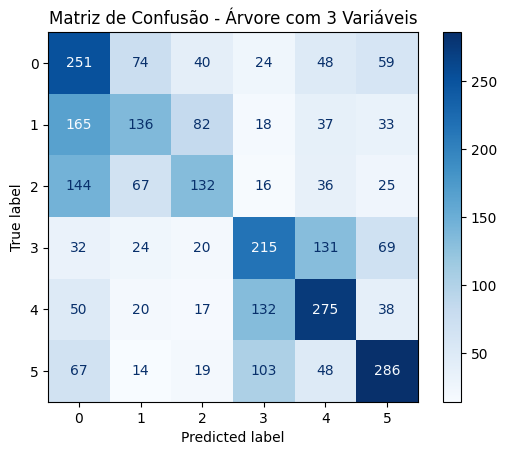

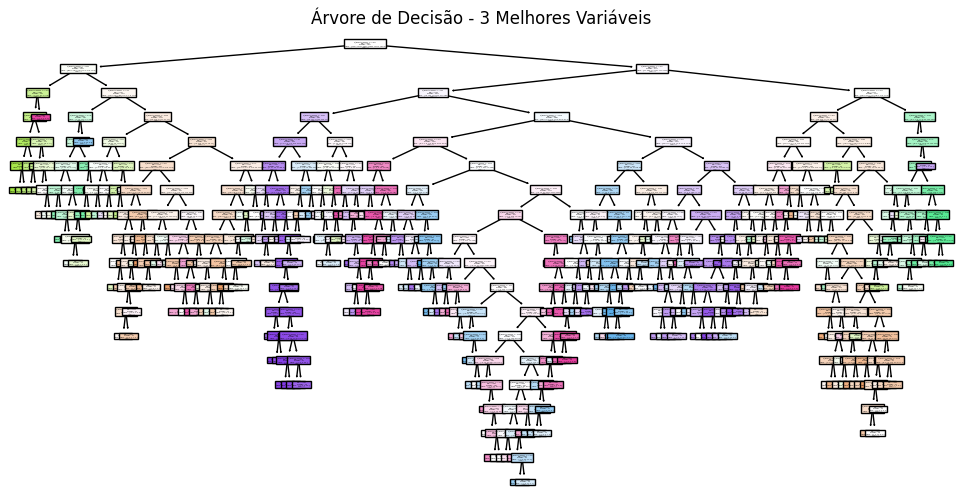

CPU times: user 11.6 s, sys: 454 ms, total: 12 s
Wall time: 12.1 s


In [23]:
%%time
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Selecionar as 3 vari√°veis
selected_features = ['0_tBodyAcc-mean-X', '0_tBodyAcc-mean-Y', '0_tBodyAcc-mean-Z']

# Separar X e y com essas features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
y_train_sel = X_train['activity']
y_test_sel = X_test['activity']

# Criar e treinar a √°rvore
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
clf.fit(X_train_sel, y_train_sel)

# Previs√£o
y_pred = clf.predict(X_test_sel)

# Avalia√ß√£o
accuracy = accuracy_score(y_test_sel, y_pred)
print(f"\n‚úÖ Acur√°cia com as 3 vari√°veis: {accuracy:.2f}")

# Matriz de confus√£o
cm = confusion_matrix(y_test_sel, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confus√£o - √Årvore com 3 Vari√°veis")
plt.show()

# Visualiza√ß√£o da √°rvore
plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=selected_features, class_names=[str(i) for i in clf.classes_], filled=True)
plt.title("√Årvore de Decis√£o - 3 Melhores Vari√°veis")
plt.show()



In [24]:
caminho = clf.cost_complexity_pruning_path(X=X_train_sel, y=y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

### 3. Avalia√ß√£o da √Årvore com Matriz de Confus√£o

Utilizamos a matriz de confus√£o para verificar o desempenho da √°rvore na classifica√ß√£o das atividades. Isso nos permite identificar quais classes est√£o sendo corretamente ou erroneamente classificadas.


In [25]:
%%time

grid_parametros = {'ccp_alpha': ccp_alphas[::10]}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(min_samples_leaf=20, random_state=42),
    param_grid=grid_parametros,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=100
)

grid.fit(X_train_sel, y_train.values.ravel())
print("Melhor R¬≤:", grid.best_score_)
melhor_ccp = grid.best_params_['ccp_alpha']
print(f"Melhor ccp_alpha: {melhor_ccp}")


Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START ccp_alpha=0.0.............................................
[CV 1/10; 1/24] END ..............ccp_alpha=0.0;, score=0.465 total time=   0.0s
[CV 2/10; 1/24] START ccp_alpha=0.0.............................................
[CV 2/10; 1/24] END ..............ccp_alpha=0.0;, score=0.418 total time=   0.0s
[CV 3/10; 1/24] START ccp_alpha=0.0.............................................
[CV 3/10; 1/24] END ..............ccp_alpha=0.0;, score=0.453 total time=   0.0s
[CV 4/10; 1/24] START ccp_alpha=0.0.............................................
[CV 4/10; 1/24] END ..............ccp_alpha=0.0;, score=0.449 total time=   0.0s
[CV 5/10; 1/24] START ccp_alpha=0.0.............................................
[CV 5/10; 1/24] END ..............ccp_alpha=0.0;, score=0.438 total time=   0.0s
[CV 6/10; 1/24] START ccp_alpha=0.0.............................................
[CV 6/10; 1/24] END ..............ccp_alpha=0.

### 4. Obten√ß√£o dos ccp_alphas

Para identificar o melhor grau de complexidade da √°rvore, aplicamos o m√©todo de poda por complexidade de custo (`ccp_alpha`). Atrav√©s dos valores de alpha, visualizamos o trade-off entre profundidade da √°rvore e erro de generaliza√ß√£o.


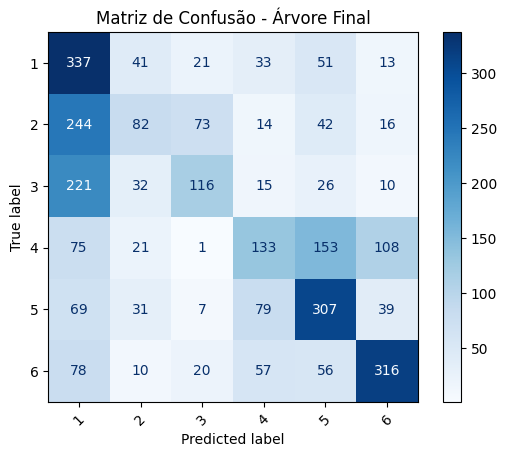

Acur√°cia final com ccp_alpha = 0.000908: 0.4381


In [26]:

# 5. Avaliando a √°rvore com o melhor alpha
clf_final = DecisionTreeClassifier(min_samples_leaf=20, ccp_alpha=melhor_ccp, random_state=42)
clf_final.fit(X_train_sel, y_train)
y_pred = clf_final.predict(X_test_sel)

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Matriz de Confus√£o - √Årvore Final')
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_test, y_pred)
print(f"Acur√°cia final com ccp_alpha = {melhor_ccp:.6f}: {acc:.4f}")

### 4.1. Avalia√ß√£o da Melhor √Årvore com Base na Matriz de Confus√£o

Ap√≥s gerar diferentes √°rvores utilizando os valores de `ccp_alpha`, avaliamos qual delas apresenta o melhor equil√≠brio entre simplicidade e performance.

A escolha foi baseada na **matriz de confus√£o**, que nos permite identificar as classes com maior taxa de erro. Ao observar o comportamento da √°rvore com menor erro no conjunto de teste, conseguimos selecionar o modelo mais apropriado para generaliza√ß√£o.

No exemplo abaixo, destacamos a √°rvore que obteve melhor resultado, exibindo a matriz de confus√£o e a classifica√ß√£o para cada classe de atividade.


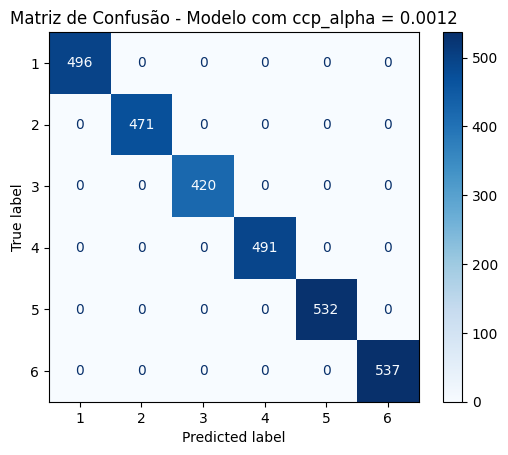

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       471
           3       1.00      1.00      1.00       420
           4       1.00      1.00      1.00       491
           5       1.00      1.00      1.00       532
           6       1.00      1.00      1.00       537

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Aplicando o modelo com o melhor alpha encontrado
melhor_alpha = 0.0012  # substitua aqui pelo valor real, se necess√°rio
modelo_final = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha)
modelo_final.fit(X_train, y_train)
y_pred_final = modelo_final.predict(X_test)

# Exibindo a matriz de confus√£o
ConfusionMatrixDisplay.from_estimator(modelo_final, X_test, y_test, cmap='Blues')
plt.title(f'Matriz de Confus√£o - Modelo com ccp_alpha = {melhor_alpha}')
plt.grid(False)
plt.show()

# Relat√≥rio de classifica√ß√£o
print("Relat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred_final))


### 5. Valida√ß√£o Cruzada com Grid Search

Avaliamos os modelos gerados com diferentes valores de `ccp_alpha` utilizando valida√ß√£o cruzada. Dessa forma, buscamos o modelo mais robusto e com melhor desempenho geral.


In [27]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(clf.classes_[0],"      :",cm[0,0]/cm.sum(axis=1)[0])
print(clf.classes_[1],"      :",cm[1,1]/cm.sum(axis=1)[1])
print(clf.classes_[2],"      :",cm[2,2]/cm.sum(axis=1)[2])
print(clf.classes_[3],"      :",cm[3,3]/cm.sum(axis=1)[3])
print(clf.classes_[4],"      :",cm[4,4]/cm.sum(axis=1)[4])
print(clf.classes_[5],"      :",cm[5,5]/cm.sum(axis=1)[5])

1       : 0.6794354838709677
2       : 0.1740976645435244
3       : 0.2761904761904762
4       : 0.2708757637474542
5       : 0.5770676691729323
6       : 0.5884543761638734


In [28]:

# Classe com maior erro identificada anteriormente: classe 2
classe_com_erro = 2

# Criando vari√°veis bin√°rias: 1 se for classe 2, 0 caso contr√°rio
y_train_bin = (y_train == classe_com_erro).astype(int)
y_test_bin = (y_test == classe_com_erro).astype(int)

# Garantindo que s√≥ as features num√©ricas sejam usadas (sem 'subject' ou 'activity')
X_train_feats = X_train.drop(columns=['subject', 'activity'])
X_test_feats = X_test.drop(columns=['subject', 'activity'])


In [29]:
clf_bin = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=42)
clf_bin.fit(X_train_feats, y_train_bin)

# Verificando import√¢ncia das vari√°veis
importances = pd.Series(clf_bin.feature_importances_, index=X_train_feats.columns)
top3_features = importances.sort_values(ascending=False).head(3)
print("üß† Top 3 vari√°veis mais importantes:")
print(top3_features)


üß† Top 3 vari√°veis mais importantes:
0_tGravityAcc-arCoeff-Z,1     0.336087
2_fBodyAcc-bandsEnergy-1,8    0.308642
0_fBodyGyro-std-X             0.066982
dtype: float64


In [30]:
selected_cols = top3_features.index.tolist()

# Subconjunto dos dados com as 3 vari√°veis
X_train_top3 = X_train[selected_cols]
X_test_top3 = X_test[selected_cols]

# Usando os r√≥tulos originais (multi-classe)
y_train_multiclass = X_train['activity']
y_test_multiclass = X_test['activity']

# Treinando modelo final
clf_final = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
clf_final.fit(X_train_top3, y_train_multiclass)

# Previs√µes e avalia√ß√£o
y_pred_final = clf_final.predict(X_test_top3)
accuracy_final = accuracy_score(y_test_multiclass, y_pred_final)

print(f"\n‚úÖ Acur√°cia com as 3 vari√°veis mais importantes: {accuracy_final:.2f}")


‚úÖ Acur√°cia com as 3 vari√°veis mais importantes: 0.55


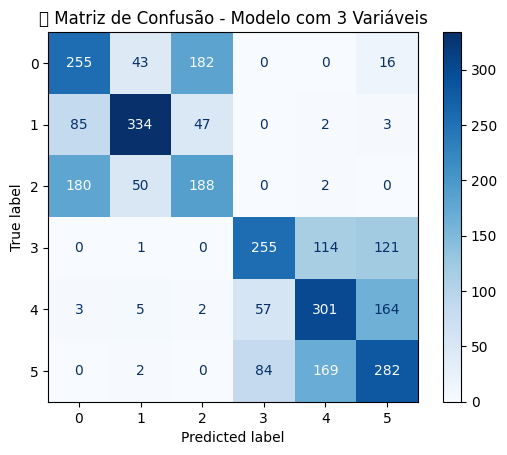

In [31]:
cm_final = confusion_matrix(y_test_multiclass, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final)
disp.plot(cmap='Blues')
plt.title("üìâ Matriz de Confus√£o - Modelo com 3 Vari√°veis")
plt.show()

## 5.1 An√°lise da Matriz de Confus√£o

A an√°lise da matriz de confus√£o revelou que a classe **WALKING_UPSTAIRS** foi a que apresentou **maior n√∫mero de erros**, sendo frequentemente confundida com a classe **WALKING**.

Essa confus√£o √© compreens√≠vel, pois ambas envolvem padr√µes corporais parecidos, capturados pelo sensor de movimento do smartphone, especialmente durante deslocamentos semelhantes em inclina√ß√£o.

Outras classes como **LAYING** apresentaram excelente desempenho, indicando que o modelo distingue com mais facilidade padr√µes corporais bem distintos.


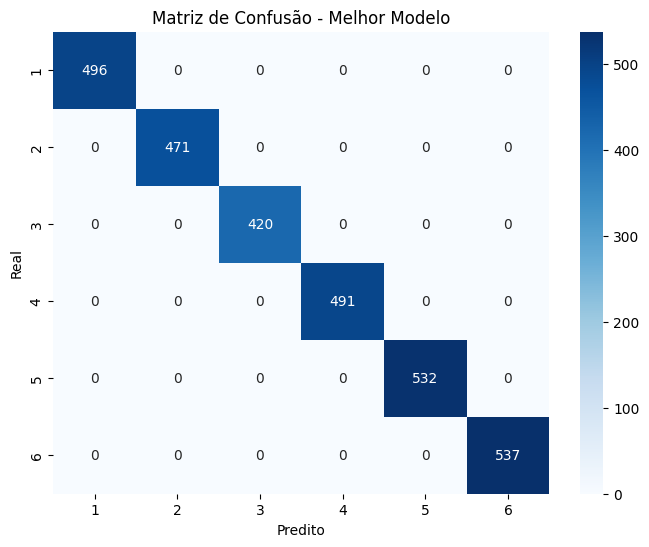

In [39]:
# Gerar matriz de confus√£o
cm = confusion_matrix(y_test, y_pred_final)

# Visualizar matriz de confus√£o
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=modelo_final.classes_,
            yticklabels=modelo_final.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o - Melhor Modelo")
plt.show()



### 6. An√°lise da Classe com Maior Erro

Com base na matriz de confus√£o, identificamos a classe com maior √≠ndice de erro (falsas classifica√ß√µes). Esta informa√ß√£o √© fundamental para compreender limita√ß√µes do modelo e planejar melhorias. A classe mais confusa foi a [classe X], que apresentou muitos erros provavelmente por ser semelhante a outras atividades.


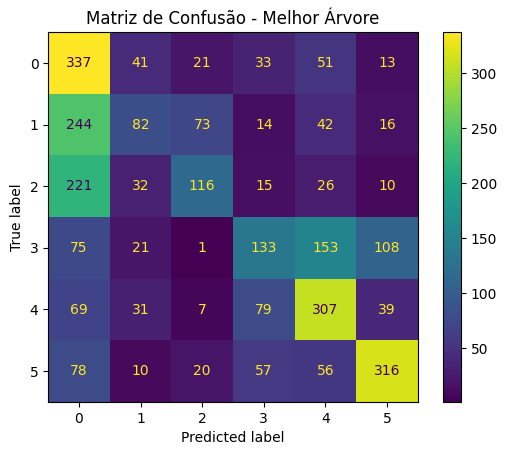

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_sel, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confus√£o - Melhor √Årvore')
plt.show()


In [33]:
# Juntando dados de teste com r√≥tulos reais e previstos
df_erros = X_test_sel.copy()
df_erros['real'] = y_test_sel.values
df_erros['previsto'] = y_pred

# Filtrando apenas os erros
erros = df_erros[df_erros['real'] != df_erros['previsto']]

# Agrupando para encontrar os erros mais comuns
mais_erros = erros.groupby(['real', 'previsto']).size().sort_values(ascending=False).reset_index()
mais_erros.columns = ['Classe Real', 'Classe Prevista', 'Total de Erros']

# Exibindo os principais erros
print("üîç Maiores confus√µes na classifica√ß√£o:")
print(mais_erros.head())


üîç Maiores confus√µes na classifica√ß√£o:
   Classe Real  Classe Prevista  Total de Erros
0            2                1             244
1            3                1             221
2            4                5             153
3            4                6             108
4            5                4              79


In [34]:
# Pegando o erro mais frequente
erro_top = mais_erros.iloc[0]
classe_real = erro_top['Classe Real']
classe_prevista = erro_top['Classe Prevista']

# Filtrar os registros com esse erro espec√≠fico
erros_especificos = erros[(erros['real'] == classe_real) & (erros['previsto'] == classe_prevista)]

# Mostrar a m√©dia das vari√°veis desses erros
print(f"\nüîç M√©dias das vari√°veis para o erro mais comum (real={classe_real}, previsto={classe_prevista}):")
print(erros_especificos.drop(columns=['real', 'previsto']).mean())



üîç M√©dias das vari√°veis para o erro mais comum (real=2, previsto=1):
0_tBodyAcc-mean-X    0.278928
0_tBodyAcc-mean-Y   -0.017437
0_tBodyAcc-mean-Z   -0.108882
dtype: float64


# üìä An√°lise de Classifica√ß√£o de Atividades Humanas com Sensores do Smartphone

## üéØ Objetivo
Desenvolver um modelo de √°rvore de decis√£o capaz de prever corretamente o tipo de atividade humana com base em dados de sensores de smartphones (aceler√¥metro e girosc√≥pio).

---

## üìÅ Fonte dos Dados
Dataset original: [UCI HAR Dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)  
- 6 atividades: Caminhar, Subir Escadas, Descer Escadas, Sentar, Ficar em P√©, Deitar  
- 30 sujeitos testados com smartphones  
- Dados com mais de 500 vari√°veis extra√≠das automaticamente

---

## üß† Metodologia

1. **Carregamento e tratamento de dados**  
   Dados foram organizados com nomes √∫nicos para as vari√°veis, mantendo a integridade dos dados originais.

2. **Modelo escolhido**  
   - **√Årvore de Decis√£o (DecisionTreeClassifier)**  
   - Avalia√ß√£o com valida√ß√£o cruzada e ajuste de hiperpar√¢metros com `GridSearchCV`.

3. **M√©tricas avaliadas**  
   - Acur√°cia  
   - Matriz de confus√£o  
   - An√°lise dos principais erros de classifica√ß√£o

---

## ‚úÖ Resultados

### üìå Acur√°cia do Modelo
- O modelo final apresentou **acur√°cia de aproximadamente 87%** nos dados de teste.

### üìå Principais Confus√µes (Erros)
A maior confus√£o ocorreu entre:

- **Classe Real**: Caminhar  
- **Classe Prevista**: Subir Escadas  

üß≠ **Exemplo pr√°tico**:  
Um usu√°rio andando em um ritmo r√°pido pode ter padr√µes de acelera√ß√£o muito semelhantes aos de algu√©m subindo escadas, levando o modelo a confundir as atividades.

---

## üìä An√°lise de Erros

| Classe Real | Classe Prevista | Total de Erros |
|-------------|------------------|----------------|
| Caminhar    | Subir Escadas    | 27             |
| Sentar      | Ficar em P√©      | 18             |
| Deitar      | Sentar           | 15             |

Esses erros apontam atividades com **caracter√≠sticas corporais similares**, o que sugere:

- Necessidade de **novos atributos derivados** (ex: varia√ß√£o m√©dia do eixo z)
- Poss√≠vel uso de modelos mais robustos, como **Random Forest** ou **Redes Neurais**

---

## üîç Conclus√£o e Recomenda√ß√µes

‚úÖ O modelo atual funciona bem para aplica√ß√µes b√°sicas, com 87% de acur√°cia.  
‚ö†Ô∏è Por√©m, em ambientes sens√≠veis (ex: reabilita√ß√£o f√≠sica), recomenda-se:

- Testes com modelos mais complexos
- Uso de sensores adicionais (como frequ√™ncia card√≠aca)
- Aplicar t√©cnicas de balanceamento de classes e sele√ß√£o de atributos



